# Packages and Authentication

In [1]:
import ee
import folium
import io
from PIL import Image
import requests
import shutil

from io import BytesIO
import matplotlib.pyplot as plt

import pandas as pd


In [2]:
# Authenticate with Google Account and initialize the project
ee.Authenticate()

ee.Initialize(project='master-thesis-410713')

In [3]:
%cd /content/drive/MyDrive/Master Thesis/01 Data Acquisition

/content/drive/MyDrive/Master Thesis/01 Data Acquisition


# Load collection

In [4]:
# Load Datasets
neth = ee.ImageCollection('Netherlands/Beeldmateriaal/LUCHTFOTO_RGB')
brand = ee.Image('Germany/Brandenburg/orthos/20cm')
switz = ee.ImageCollection('Switzerland/SWISSIMAGE/orthos/10cm')

# Information about Collections/ Image

## Information functions

In [5]:
def give_number_images(collection):
    # Print the number of images in the collection
    count = collection.size()
    out = print('Count: ', count.getInfo())
    return out

In [6]:
def get_image_info(image_id):
    # Load the image
    image = ee.Image(image_id)

    # Fetch and print some basic information about the image
    info = image.getInfo()
    image_id = info['id']
    image_properties = info['properties']

    # You can extract specific properties like this:
    # acquisition_time = ee.Date(image.get('system:time_start')).format().getInfo()

    return {
        'Image ID': image_id,
        'Properties': image_properties
    }

In [7]:
def give_image_info(collection):
    # Print the avaliable information for the first image of the collection
    first_image_info = collection.first().getInfo()
    out = print(first_image_info)
    return out

In [8]:
def give_date(collection):
    # Aggregate date strings
    dates = collection.aggregate_array('system:time_start')

    # Convert milliseconds to dates
    def convertToDate(milliseconds):
        return ee.Date(milliseconds).format()

    # Map the conversion function over the array
    dateStrings = dates.map(convertToDate)

    # Remove duplicates
    uniqueDates = ee.List(dateStrings).distinct()

    # Load information
    uniqueDateList = uniqueDates.getInfo()

    out = []

    # Save the unique dates
    for date in uniqueDateList:
        out.append(date)

    return out

## Inspect Switzerland collection

In [9]:
give_number_images(switz)
give_image_info(switz)
give_date(switz)

Count:  5
{'type': 'Image', 'bands': [{'id': 'R', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [1610000, 1040000], 'crs': 'EPSG:2056', 'crs_transform': [0.1, 0, 2517000, 0, -0.1, 1182000]}, {'id': 'G', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [1610000, 1040000], 'crs': 'EPSG:2056', 'crs_transform': [0.1, 0, 2517000, 0, -0.1, 1182000]}, {'id': 'B', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [1610000, 1040000], 'crs': 'EPSG:2056', 'crs_transform': [0.1, 0, 2517000, 0, -0.1, 1182000]}], 'version': 1681511810709725, 'id': 'Switzerland/SWISSIMAGE/orthos/10cm/2017', 'properties': {'system:time_start': 1483228800000, 'system:footprint': {'type': 'LinearRing', 'coordinates': [[7.142325257775828, 46.788781061576344], [6.9446535320725715, 46.78809542334516], [6.681101268059337, 46.78664843042711], [6.351684118205881, 46.78398450541759], [6.37025930080

['2017-01-01T00:00:00',
 '2018-01-01T00:00:00',
 '2019-01-01T00:00:00',
 '2020-01-01T00:00:00',
 '2021-01-01T00:00:00']

## Inspect Brandenburg collection

In [148]:
get_image_info(brand)

{'Image ID': 'Germany/Brandenburg/orthos/20cm',
 'Properties': {'system:footprint': {'type': 'LinearRing',
   'coordinates': [[11.341171653029834, 52.20308425844391],
    [11.363679759194229, 51.92717620255713],
    [11.385829808856709, 51.651248245909215],
    [11.413025424983715, 51.306308850126186],
    [13.316327402240152, 51.3491633300837],
    [14.798924638366016, 51.361090082088005],
    [14.795833718537521, 52.05229997171448],
    [14.793272301142224, 52.60520890851888],
    [14.79062620933035, 53.15806590940618],
    [14.788581765317643, 53.57267803720505],
    [14.23174189582351, 53.57039989247333],
    [13.341090907576637, 53.56136303329483],
    [12.45110002559135, 53.54570119853805],
    [11.784279117110223, 53.52961456102281],
    [11.229124166855483, 53.51337579136204],
    [11.27142055089249, 53.03068827737222],
    [11.31829779543054, 52.47897242498684],
    [11.341171653029834, 52.20308425844391]]},
  'system:asset_size': 3057244845757,
  'system:index': '20cm'}}

# Folium Maps

### Folium Function

In [188]:
# Define function to display folium maps by coordinates

def create_folium_map(ee_object, coordinates, vis_params = {}, zoom_start = 15, width = 500, height = 500, layer_control=False):

    def add_ee_layer(self, ee_image_object, vis_params, name):
        map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
        folium.raster_layers.TileLayer(
            tiles=map_id_dict['tile_fetcher'].url_format,
            attr='Map Data &copy; Google Earth Engine',
            name=name,
            overlay=True,
            control=True
        ).add_to(self)

    # Add method to Folium
    folium.Map.add_ee_layer = add_ee_layer

    # Define map characteristics
    map = folium.Map(width=width,
                     height=height,
                     location=coordinates,
                     zoom_start=zoom_start,
                     max_zoom = 22,
                     zoom_control=False)

    # Check if the input is a collection or a single image

    if isinstance(ee_object, ee.imagecollection.ImageCollection):
        # Use median image from collection
        map.add_ee_layer(ee_object.median(), vis_params, 'Collection Map')
    elif isinstance(ee_object, ee.image.Image):
        # Use the image directly
        map.add_ee_layer(ee_object, vis_params, 'EE Image')
    else:
        raise ValueError("The ee_object must be either an ImageCollection or an Image.")

    if layer_control:
        folium.LayerControl().add_to(map)

    return map

### Netherlands

In [14]:
### Define test colleciton, location and params for Netherlands

# Define the ImageCollection
neth_new = neth.filterDate('2022-01-01', '2023-01-01')

# Define location
parking_spot_coor_neth = [51.776752, 5.259882]

# Define visualization parameters
vis_params_neth = {
    'min': 0,
    'max': 255,
    'bands': ['R', 'G', 'B']
}

In [190]:
# Create Folium Map
test_map_neth = create_folium_map(neth_new, parking_spot_coor_neth, zoom_start = 18)

In [191]:
test_map_neth

In [19]:
# Save test image
img_data = test_map_neth._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('TestMap2.png')

### Switzerland

In [15]:
### Define test colleciton, location and params for Switzerland

# Define the ImageCollection
switz_new = switz.filterDate('2017-01-01', '2023-01-01')

# Define location
parking_spot_coor_switz = [46.878674, 7.541460]

# Define visualization parameters
vis_params_switz = {
    'min': 0,
    'max': 255,
    'bands': ['R', 'G', 'B']
}

In [193]:
# Create Folium Map
test_map_switz = create_folium_map(switz_new, parking_spot_coor_switz, zoom_start = 18)

In [194]:
test_map_switz

In [39]:
# Save test iamge
img_data = test_map_switz._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('test_map_switz2.png')

### Brandenburg

In [16]:
### Define location and params for Switzerland

# Define location
parking_spot_coor_brand = [52.303488, 13.020502]

# Define visualization parameters
vis_params_brand = {
    'min': 0,
    'max': 255,
    'bands': ['R', 'G', 'B']
}

In [196]:
test_map_brand = create_folium_map(brand, parking_spot_coor_brand, zoom_start = 18)

In [197]:
test_map_brand

# Download Images

## Via URL download **link**

### Functions

In [34]:
def generate_image_url(ee_object, coordinates, vis_params={}, buffer_distance=200, dimensions=50):

    # Define a point with the given longitude and latitude coordinates
    point = ee.Geometry.Point(coordinates)

    # Check if the input is a collection or a single image
    if isinstance(ee_object, ee.imagecollection.ImageCollection):
        # Filter the collection using the point and select the first image
        filtered_collection = ee_object.filterBounds(point)
        image = filtered_collection.first()
    elif isinstance(ee_object, ee.image.Image):
        # Use the image directly
        image = ee_object
    else:
        raise ValueError("The ee_object must be either an ImageCollection or an Image.")

    # Use the visualize method to convert the image to an RGB image
    visualized_image = image.visualize(**vis_params)

    # Define a smaller region of interest via buffer
    roi = point.buffer(buffer_distance)

    # Get the URL
    url = visualized_image.getThumbURL({
        'region': roi,
        'dimensions': dimensions,
        'format': 'png'
    })

    return url

In [11]:
# Define visualization function from url

def show_image_from_url(url, size=None):  # Size is in inches
    response = requests.get(url)
    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))

        if size != None:
        # Set the size of the figure
            plt.figure(figsize=size)

        plt.imshow(img)
        plt.axis('off')  # Turn off axis numbers
        plt.show()
    else:
        print("Failed to show image. Status code:", response.status_code)

In [12]:
# Define downloading function

def download_image_via_url(url, save_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
    else:
        print("Failed to download image. Status code:", response.status_code)

### Test functions

In [40]:
# Specify test image information

coordinates = [5.259882, 51.776752]
#coordinates = [7.541460, 46.878674]
#coordinates = [13.020502, 52.303488]
data_set = neth_new
data_set_name = "neth_new"
vis_params = {'min': 0, 'max': 255, 'bands': ['R', 'G', 'B']}
image_name = f'testimage_{data_set_name}_{coordinates[0]}_{coordinates[1]}_2048'

In [41]:
image_name

'testimage_neth_new_5.259882_51.776752_2048'

In [42]:
# Generate test url

url = generate_image_url(data_set, coordinates, vis_params, dimensions = 2048)

print(url)

https://earthengine.googleapis.com/v1/projects/master-thesis-410713/thumbnails/2a0125ed9bd6b0d31c8055c53d2a880c-56d440ce2b802a8809e799b545788d44:getPixels


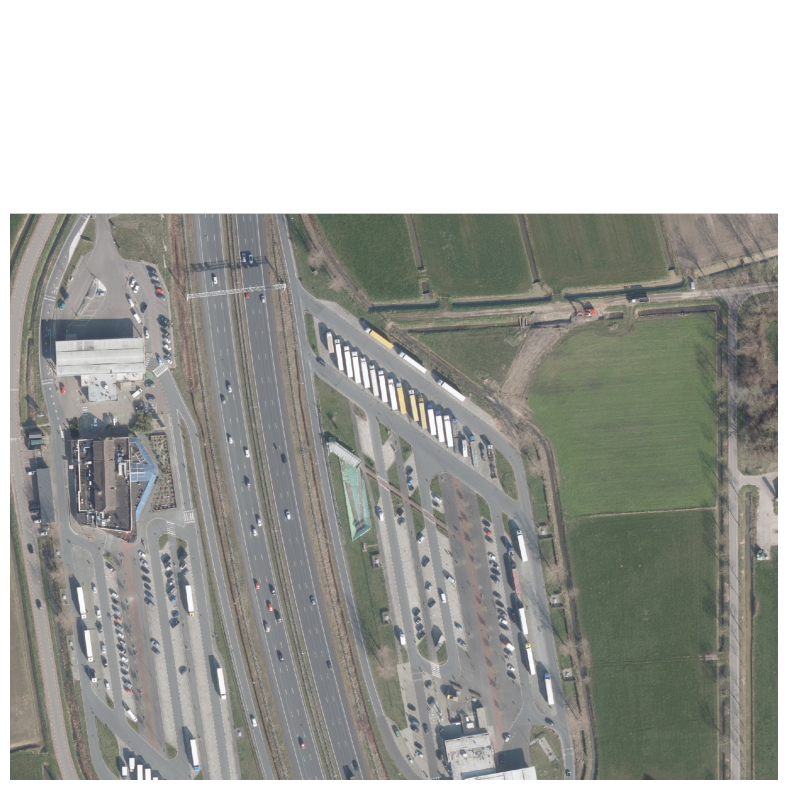

In [44]:
# Show test image

show_image_from_url(url, size=(10,10))  # Change the size as needed, or None

In [43]:
# Download test image

download_path = f'/content/drive/MyDrive/Master Thesis/01 Data Acquisition/01a Earth Engine Images/{image_name}.png'
download_image_via_url(url, download_path)

### Test to download from polygons (not working yet)

In [260]:
truck_parking_netherlands = pd.read_csv('/content/drive/MyDrive/Master Thesis/01 Data Acquisition/01b Truck Parking GeoJSON/netherlands_truck_parking_100_motorway_new_csv')

In [261]:
truck_parking_netherlands

,osm_version,osm_way_id,name,osm_timestamp,geometry,all_tags,hgv,parking,capacity,amenity
0,NaN,10129384,NaN,NaN,"POLYGON((6.8545085, 52.2831689, 6.8537502, 52....","@id=""relation/10129384"", amenity=""parking"", hg...",yes,surface,NaN,parking
1,NaN,59757113,Knauheide,NaN,"POLYGON((6.1671087, 51.8964039, 6.1672936, 51....","@id=""way/59757113"", access=""yes"", alt_name=""Gr...",designated,surface,NaN,parking
2,NaN,165964683,NaN,NaN,"POLYGON((5.7577826, 51.4160636, 5.7597002, 51....","@id=""way/165964683"", amenity=""parking"", hgv=""d...",designated,surface,NaN,parking
3,NaN,191095544,A16 Hazeldonk-Oost,NaN,"POLYGON((4.7425562, 51.4980201, 4.7426096, 51....","@id=""way/191095544"", amenity=""parking"", hgv=""d...",designated,surface,NaN,parking
4,NaN,191095545,A16 Hazeldonk-West,NaN,"POLYGON((4.740918, 51.4974075, 4.7409901, 51.4...","@id=""way/191095545"", amenity=""parking"", hgv=""d...",designated,surface,NaN,parking
...,...,...,...,...,...,...,...,...,...,...
109,NaN,9552496934,NaN,NaN,"POLYGON((6.1837673, 51.3934824))","@id=""node/9552496934"", amenity=""parking"", hgv=...",yes,NaN,NaN,parking
110,NaN,9575938491,NaN,NaN,"POLYGON((4.2897158, 51.3963984))","@id=""node/9575938491"", amenity=""parking"", hgv=...",yes,NaN,NaN,parking
111,NaN,10176321706,NaN,NaN,"POLYGON((5.1508964, 51.5452482))","@id=""node/10176321706"", amenity=""parking"", hgv...",yes,surface,NaN,parking
112,NaN,10176342663,NaN,NaN,"POLYGON((4.9120433, 51.5539376))","@id=""node/10176342663"", amenity=""parking"", hgv...",designated,surface,NaN,parking


In [262]:
test_example = truck_parking_netherlands.iloc[0,:]

In [273]:
test_polygon = test_example["geometry"]
coordinates = test_polygon
test_polygon

'POLYGON((6.8545085, 52.2831689, 6.8537502, 52.283755, 6.8525103, 52.2847934, 6.8508942, 52.2842461, 6.8509747, 52.2841559, 6.8508366, 52.2841042, 6.850677, 52.2837719, 6.8513717, 52.2830672, 6.8519969, 52.2833143, 6.8528469, 52.2824979, 6.8545085, 52.2831689, 6.8509787, 52.2839647, 6.851493, 52.2834224, 6.8514977, 52.283411, 6.8514857, 52.2834023, 6.8514736, 52.2834019, 6.8514521, 52.2834081, 6.8509331, 52.2839483, 6.8509345, 52.2839697, 6.8509532, 52.2839729, 6.8509787, 52.2839647, 6.8528898, 52.2838097, 6.8521509, 52.2835439, 6.8519779, 52.2835906, 6.8517834, 52.2839869, 6.8518947, 52.2840222, 6.852525, 52.2842355, 6.8528677, 52.2838372, 6.8528898, 52.2838097))'

In [275]:
def generate_image_url(ee_object, wkt_polygon, vis_params={}, dimensions=50):

    # Convert WKT string to ee.Geometry.Polygon
    polygon = ee.Geometry.Polygon(ee.Geometry.Polygon(wkt_polygon))
    return polygon

In [271]:
data_set = neth_new
data_set_name = "neth_new"
vis_params = {'min': 0, 'max': 255, 'bands': ['R', 'G', 'B']}
image_name = f'testimage_{data_set_name}_{coordinates[0]}_{coordinates[1]}'

In [276]:
# Generate test url

url = generate_image_url(data_set, coordinates, vis_params, dimensions = 512)

print(url)

EEException: Invalid geometry.

## Via Export Options (not working yet)

In [240]:
def download_image_to_Drive(collection, coordinates, vis_params = {}, buffer_distance=50, dimensions=1028):

    # Define a point with the given longitude and latitude coordinates
    point = ee.Geometry.Point(coordinates)

    # Filter the collection using the point
    filtered_collection = collection.filterBounds(point)

    # Select an individual image from the filtered collection
    selected_image = filtered_collection.first()

    # Use the visualize method to convert the image to an RGB image
    visualized_image = selected_image.visualize(**vis_params)

    # Define a smaller region of interest via buffer
    roi = point.buffer(buffer_distance)

    # Export the image to Google Drive.
    task = ee.batch.Export.image.toDrive(
        image=visualized_image,
        description='image_export1',
        folder="TestDownloadEENeth",
        region=roi,
        scale=dimensions,
        fileFormat="GeoTIFF"
        )

    # Start the export task.
    task.start()

In [241]:
# Test function
coordinates = [5.259882, 51.776752]
vis_params = {'min': 0, 'max': 255, 'bands': ['R', 'G', 'B']}
download_image_to_Drive(neth_new, coordinates, vis_params)

In [245]:
# Test function
coordinates = [46.878674, 7.541460]
vis_params = {'min': 0, 'max': 255, 'bands': ['R', 'G', 'B']}
collection = switz_new = switz.filterDate('2017-01-01', '2023-01-01')
url = generate_image_url(collection, coordinates, vis_params)

EEException: Image.visualize: Parameter 'image' is required.